In [13]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout

from sklearn.preprocessing import MinMaxScaler

In [4]:
final_daily = pd.read_csv('dash_app/data/resampled/final_daily.csv')
final_daily['Datetime'] = pd.to_datetime(final_daily.loc[:,'Datetime'], infer_datetime_format=True)
final_daily = final_daily.set_index('Datetime')

In [8]:
decomposition = seasonal_decompose(final_daily["Global_active_power"])

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


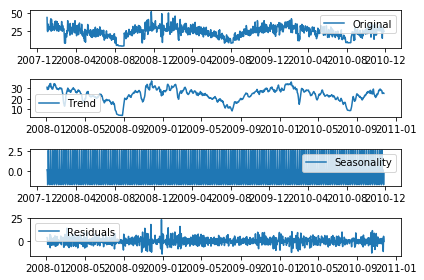

In [11]:
plt.subplot(411)
plt.plot(final_daily["Global_active_power"], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [21]:
def split_data(data):
    train, test = data[4:data.shape[0] - 210], data[data.shape[0] - 210:data.shape[0]]
    train = np.array(np.split(train, int(len(train)/7)))
    test = np.array(np.split(test, int(len(test)/7)))
    return train, test

In [23]:
data = final_daily["Global_active_power"]
train, test = data[4:data.shape[0] - 210], data[data.shape[0] - 210:data.shape[0]]
model = ARIMA(train, order=(5,1,0))
model_fit = model.fit(disp=0)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [88]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('%s(t-%d)' % (data.columns[j], i)) for j in range(n_vars)]
    for i in range(0, n_out):
        cols.append(dff["Global_active_power"].shift(-i))
#         names.append("Global_active_power(t+%d)" % i)
        if i != 0:
            names.append("Global_active_power(t+%d)" % i)
        else:
            names.append("Global_active_power(t)")
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    agg.dropna(inplace=True)
    return agg

In [93]:
reframed = series_to_supervised(final_daily, 20, 7)

In [135]:
print(*reframed.columns, sep = '\n')

Global_active_power(t-20)
Global_reactive_power(t-20)
Voltage(t-20)
Global_intensity(t-20)
Sub_metering_1(t-20)
Sub_metering_2(t-20)
Sub_metering_3(t-20)
Global_active_power(t-19)
Global_reactive_power(t-19)
Voltage(t-19)
Global_intensity(t-19)
Sub_metering_1(t-19)
Sub_metering_2(t-19)
Sub_metering_3(t-19)
Global_active_power(t-18)
Global_reactive_power(t-18)
Voltage(t-18)
Global_intensity(t-18)
Sub_metering_1(t-18)
Sub_metering_2(t-18)
Sub_metering_3(t-18)
Global_active_power(t-17)
Global_reactive_power(t-17)
Voltage(t-17)
Global_intensity(t-17)
Sub_metering_1(t-17)
Sub_metering_2(t-17)
Sub_metering_3(t-17)
Global_active_power(t-16)
Global_reactive_power(t-16)
Voltage(t-16)
Global_intensity(t-16)
Sub_metering_1(t-16)
Sub_metering_2(t-16)
Sub_metering_3(t-16)
Global_active_power(t-15)
Global_reactive_power(t-15)
Voltage(t-15)
Global_intensity(t-15)
Sub_metering_1(t-15)
Sub_metering_2(t-15)
Sub_metering_3(t-15)
Global_active_power(t-14)
Global_reactive_power(t-14)
Voltage(t-14)
Global_i

In [118]:
values = reframed.values

n_train_time = 210
train = values[:-n_train_time, :]
test = values[-n_train_time:, :]

scaler = MinMaxScaler(feature_range=(0, 1))
train = scaler.fit_transform(train)
test = scaler.transform(test)

In [119]:
train_X, train_y = train[:, :-7], train[:, -7:]
test_X, test_y = test[:, :-7], test[:, -7:]

In [120]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [121]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 

(825, 1, 140) (825, 7) (210, 1, 140) (210, 7)


In [128]:
model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.5))
model.add(Dense(7))
model.compile(loss='mean_squared_error', optimizer='adam')

In [132]:
history = model.fit(train_X, train_y, 
                    epochs=2000, batch_size=70, 
                    validation_data=(test_X, test_y), verbose=0, shuffle=False)


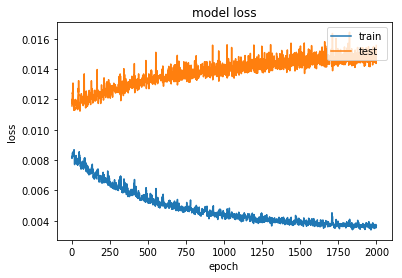

In [133]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()